In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import xarray as xr

In [6]:
import pyresample
import satpy

In [7]:
f = '../l1b/20201001T0000/g17/temp_11_00um/OR_ABI-L1b-RadF-M6C14_G17_s20202750000318_e20202750009385_c20202750009446.nc'
s = satpy.Scene([f], reader='abi_l1b')

In [8]:
name = s.available_dataset_names()[0]
s.load([name])

/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [9]:
data = s[name]

In [10]:
def get_grid(res):
    """
    res: Grid resolution (degree)
    """
    width = 360/res
    height = 180/res
    extent = [-180,-90,180,90]
    pc = pyresample.AreaDefinition('pc','','pc','+proj=latlon +lat_0=0 +lon_0=0',
                                   width=width,
                                   height=height,area_extent=extent)
    return pc

In [11]:
area = data.area
grid = get_grid(.05)

In [12]:
area.shape

(5424, 5424)

In [18]:
coords = area.get_cartesian_coords(nprocs=6)

coords_padded = np.pad(coords.astype(np.float32), ((0,0),(0,0),(0,1))).astype(np.float32)

In [28]:
coords_padded.tofile('coord_descent/sat_coords.dat')
#coords_padded.tofile('coord_descent/grid_coords.dat')

In [19]:
grid_coords = grid.get_cartesian_coords()

In [20]:
grid_coords_pad = np.pad(grid_coords, ((0,0),(0,0),(0,1))).astype(np.float32)

In [29]:
grid_coords_pad.astype(np.float32).tofile('coord_descent/grid_coords.dat')
#grid_coords_pad.astype(np.float32).tofile('coord_descent/sat_coords.dat')

In [27]:
coords_padded.dtype

dtype('float32')

In [37]:
src_index = np.memmap('./coord_descent/src_index.dat', dtype=np.uint32, mode='r')
dst_index = np.memmap('./coord_descent/dst_index.dat', dtype=np.uint32, mode='r')

In [38]:
# src_index = src_index[:min(src_index.size, dst_index.size)]
# dst_index = dst_index[:src_index.size]

In [39]:
assert src_index.size == dst_index.size
src_index.size, dst_index.size

(23046372, 23046372)

In [40]:
vals = data.values.astype(np.float32)
vals.shape

(5424, 5424)

In [53]:
r = np.full(grid.shape, np.nan)

In [42]:
bc_sum = np.bincount(dst_index, weights=vals.ravel()[src_index], minlength=r.size)
bc_count = np.bincount(dst_index, minlength=r.size)

In [54]:
r.ravel()[bc_count > 0] = bc_sum[bc_count > 0]/bc_count[bc_count > 0]

In [50]:
what_nan = np.isnan(vals.ravel()[src_index])

In [55]:
#r.ravel()[dst_index[what_nan]] = 1

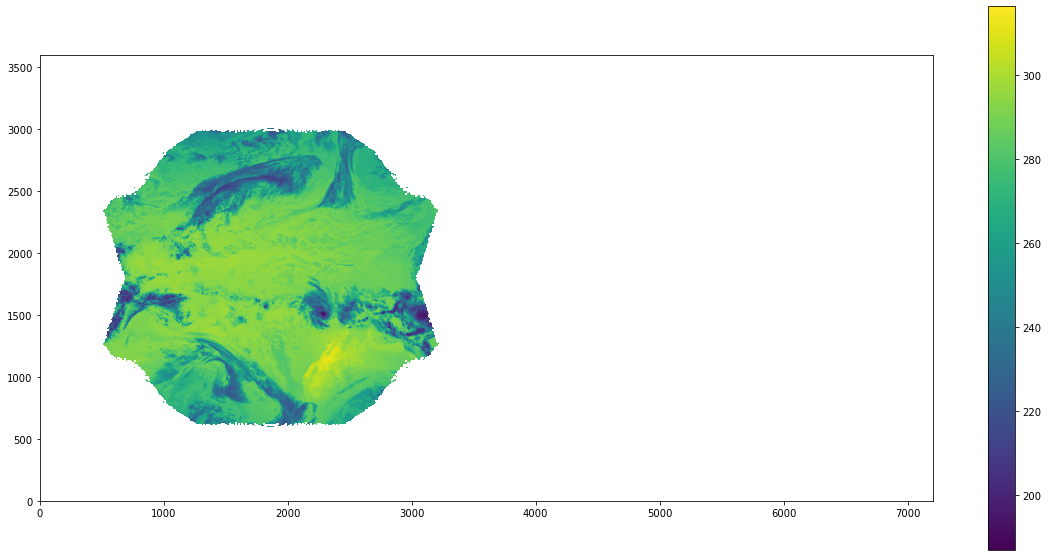

In [56]:
figure(figsize=(20,10))
imshow(np.roll(r, 1000, 1), origin='lower')
colorbar()